In [1]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *

# To activate logging
setup_logging()

## Cosmology

In [2]:
z = 1.175

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()

k=np.logspace(-5, 3, 100000)

## Gaussian mock to compare to model

In [3]:
output_dir = '/feynman/work/dphp/mp270220/outputs/'

mock_catalog = catalog_data.Data.load(output_dir+'mocks/gaussian/AbacusSummit_2Gpc_z1.175_gaussianMock0_truncatedPk_nbarx5.npy')
nbar = mock_catalog.size/mock_catalog.boxsize**3

In [4]:
cellsize = 10
resampler = 'tsc'

In [5]:
mocks_list = list()
mocks_density_list = list()
density_bins_list = list()
shot_noise_list = list()

for i in range(10):
    mock_catalog = catalog_data.Data.load(output_dir+'mocks/gaussian/AbacusSummit_2Gpc_z1.175_gaussianMock{}_truncatedPk_nbarx5.npy'.format(i))
    mocks_list.append(mock_catalog)
    mock_density = density_split.DensitySplit(mock_catalog)
    mock_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=True)
    mock_density.split_density(3)
    mocks_density_list.append(mock_density)
    density_bins_list.append(mock_density.split_bins)
    nbar = mock_catalog.size/mock_catalog.boxsize**3
    shot_noise_list.append(np.mean((mock_catalog.weights)**2)/nbar)

[000018.95]  11-14 10:13  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 117316470.
[000021.27]  11-14 10:14  CatalogMesh                  INFO     Painted 4194304 out of 117316470 objects to mesh.
[000021.27]  11-14 10:14  CatalogMesh                  INFO     Slab 4194304 ~ 8388608 / 117316470.
[000024.01]  11-14 10:14  CatalogMesh                  INFO     Painted 8388608 out of 117316470 objects to mesh.
[000024.01]  11-14 10:14  CatalogMesh                  INFO     Slab 8388608 ~ 12582912 / 117316470.
[000026.40]  11-14 10:14  CatalogMesh                  INFO     Painted 12582912 out of 117316470 objects to mesh.
[000026.40]  11-14 10:14  CatalogMesh                  INFO     Slab 12582912 ~ 16777216 / 117316470.
[000028.44]  11-14 10:14  CatalogMesh                  INFO     Painted 16777216 out of 117316470 objects to mesh.
[000028.44]  11-14 10:14  CatalogMesh                  INFO     Slab 16777216 ~ 20971520 / 117316470.
[000030.63]  11-14 10:14  CatalogMesh      

In [6]:
mean_density_bins = np.mean(np.array(density_bins_list), axis=0)

In [7]:
mean_density_bins

array([-3.09689824, -0.2246935 ,  0.2390149 ,  3.38778787])

In [8]:
mock_catalog.size

117316470

### Compute density

In [9]:
# Compute density without weights
mock_density = density_split.DensitySplit(mock_catalog)
mock_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=True)

[001554.21]  11-14 10:39  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 117316470.
[001556.35]  11-14 10:39  CatalogMesh                  INFO     Painted 4194304 out of 117316470 objects to mesh.
[001556.35]  11-14 10:39  CatalogMesh                  INFO     Slab 4194304 ~ 8388608 / 117316470.
[001558.50]  11-14 10:39  CatalogMesh                  INFO     Painted 8388608 out of 117316470 objects to mesh.
[001558.50]  11-14 10:39  CatalogMesh                  INFO     Slab 8388608 ~ 12582912 / 117316470.
[001560.54]  11-14 10:39  CatalogMesh                  INFO     Painted 12582912 out of 117316470 objects to mesh.
[001560.54]  11-14 10:39  CatalogMesh                  INFO     Slab 12582912 ~ 16777216 / 117316470.
[001562.64]  11-14 10:39  CatalogMesh                  INFO     Painted 16777216 out of 117316470 objects to mesh.
[001562.64]  11-14 10:39  CatalogMesh                  INFO     Slab 16777216 ~ 20971520 / 117316470.
[001564.70]  11-14 10:39  CatalogMesh      

### Plot density distribution

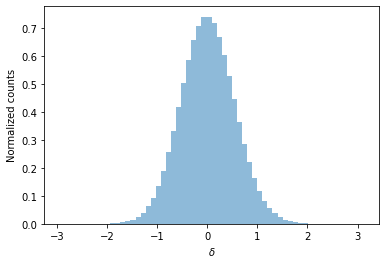

In [10]:
plt.hist(mock_density.data_densities, bins=60, density=True, alpha=0.5, label = r'10 Gaussian mocks ($\bar{{n}}$ = {:.2e})'.format(nbar))
plt.xlabel("$\delta$")
plt.ylabel("Normalized counts")
plt.show()

In [11]:
shot_noise = np.mean(np.array(shot_noise_list))
shot_noise

404.5190448471664

In [12]:
shot_noise = 404.5190448471664

In [13]:
#1/nbar

## Split model

In [14]:
kN = np.pi*1024/mock_catalog.boxsize
kN

1.6084954386379742

In [15]:
def damping_function(k, k_lambda=0.8*kN, sigma_lambda=0.05*kN):
    if k < k_lambda:
        return 1
    else:
        return np.exp(-(k-k_lambda)**2/(2*sigma_lambda**2))

In [16]:
pklin = cosmo_abacus.get_fourier().pk_interpolator(extrap_kmin=1e-6, extrap_kmax=1e3).to_1d(z)
pklin_array = pklin(k)
pkdamped_func = lambda k: pklin(k) * np.array([damping_function(kk) for kk in k])
pkdamped = PowerSpectrumInterpolator1D.from_callable(k, pkdamped_func)

In [17]:
model1 = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1)
model = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1, shot_noise=shot_noise)

model1.set_pk_model(pk=pkdamped)
model.set_pk_model(pk=pkdamped)

In [18]:
sep = np.linspace(1., 150., 150)

plt.plot(sep, sep**2 * model.xi(sep), label='R = 0 Mpc/h')

for smoothing_scale in [5, 10, 15]:
    model.set_smoothing_scale(smoothing_scale)
    model.compute_xi_R(sep=sep)
    plt.plot(sep, sep**2 * model.xi_R(sep), label='R = {} Mpc/h'.format(smoothing_scale))

plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi_R(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.legend()
plt.show()

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
model1 = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1)
model = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1, shot_noise=shot_noise)

model1.set_pk_model(pk=pkdamped)
model.set_pk_model(pk=pkdamped)

In [ ]:
mock_sigma_RR = np.std(mock_density.data_densities)
mock_sigma_RR

In [ ]:
model.sigma_RR

In [ ]:
def f(x, y, sigma_R, sigma_RR):
    left = np.sqrt(2/np.pi) * sigma_R**2 / sigma_RR * (np.exp(- y**2 / (2*sigma_RR**2)) - np.exp(- x**2 / (2*sigma_RR**2)))
    right = math.erf(y / (np.sqrt(2) * sigma_RR)) - math.erf(x / (np.sqrt(2) * sigma_RR))
    return left - right

In [ ]:
size = 100
vals = np.ndarray(shape=(size, size))
delta1 = np.linspace(-2.44, -2.4, size)
delta2 = np.linspace(-0.24, -0.2, size)

for i in range(size):
    for j in range(size):
        y = delta2[i]
        x = delta1[j]
        vals[i][j] = f(x, y, model.sigma_R, model.sigma_RR)

In [ ]:
import scipy.stats

th_bins = scipy.stats.norm.ppf(q=[0, 1./3, 2./3, 1], loc=0, scale=model.sigma_RR)

In [ ]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(10, 8))

ax = plt.gca()

from matplotlib.colors import SymLogNorm, Normalize
#normalize = Normalize(vmin=np.min(vals), vmax=np.max(vals))
normalize = SymLogNorm(linthresh=0.01, linscale=1, vmin=np.min(vals), vmax=np.max(vals), base=10)
cmap = plt.get_cmap('RdBu')
extent = np.min(delta1), np.max(delta1), np.min(delta2), np.max(delta2)
c = ax.imshow(vals, cmap=cmap, norm=normalize, extent=extent, origin='lower')

ax.axhline(th_bins[1], ls=':', color='red', label='theoretical $\delta_2$ for DS1')

for delta_bins in np.array(density_bins_list):
    print(delta_bins)
    ax.axhline(delta_bins[1], ls=':', color='purple')
    #ax.axvline(delta_bins[0], ls=':', color='purple')
ax.plot([], [], ls=':', color='purple', label='$\delta_2$ for DS1 in mocks')


ax.set_xlabel('$\delta_1$')
ax.set_ylabel('$\delta_2$')
ax.set_aspect('equal', adjustable='box')
fig.colorbar(c, ax=ax, label='$Denominator$')

plt.legend()
plt.show()

In [ ]:
# Get theoretical quantiles
import scipy.stats

th_bins = scipy.stats.norm.ppf(q=[0, 1./3, 2./3, 1], loc=0, scale=model.sigma_RR)

In [ ]:
th_bins

In [ ]:
model.sigma_R

In [ ]:
mock_density.split_density(3)

In [ ]:
mock_density.split_bins

In [ ]:
mean_density_bins

## Compute density split CCFs (randoms-tracers)

In [ ]:
ccf_randoms_tracers = model.ccf_randoms_tracers(density_bins=th_bins)
ccf_randoms_tracers1 = model1.ccf_randoms_tracers(density_bins=th_bins)

In [ ]:
plt.rcParams["figure.figsize"] = (20, 5)
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

s = model.sep

for i in range(model.nsplits):
    axes[i].plot(s, s**2 * ccf_randoms_tracers[i], label='With shot noise')
    axes[i].plot(s, s**2 * ccf_randoms_tracers1[i], label='No shot noise')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()

plt.suptitle('Cross-correlation randoms-halos', y=1.05)
plt.show()

In [ ]:
mocks_split_results_1Gpc = np.load(output_dir+'correlation_functions/AbacusSummit_1Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_densitySplit_rh_CCF_cellsize10_randomsize4.npy', allow_pickle=True)
mocks_xiell_rh_1Gpc, cov_rh_1Gpc = get_split_poles(mocks_split_results_1Gpc, ells=[0], nsplits=model.nsplits)
std_rh_1Gpc = np.array_split(np.array(np.array_split(np.diag(cov_rh_1Gpc)**0.5, 1)), model.nsplits, axis=1)/np.sqrt(10)

In [ ]:
mocks_split_results_2Gpc = np.load(output_dir+'AbacusSummit_2Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_densitySplit_rh_CCF_cellsize10_randomsize4_all.npy', allow_pickle=True)
mocks_xiell_rh_2Gpc, cov_rh_2Gpc = get_split_poles(mocks_split_results_2Gpc, ells=[0], nsplits=model.nsplits)
std_rh_2Gpc = np.array_split(np.array(np.array_split(np.diag(cov_rh_2Gpc)**0.5, 1)), model.nsplits, axis=1)/np.sqrt(10)

In [ ]:
mocks_split_results_2Gpc_fixedBins = np.load(output_dir+'AbacusSummit_2Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_densitySplit_fixedBins_rh_CCF_cellsize10_randomsize4_all.npy', allow_pickle=True)
mocks_xiell_rh_2Gpc_fixedBins, cov_rh_2Gpc_fixedBins = get_split_poles(mocks_split_results_2Gpc_fixedBins, ells=[0], nsplits=model.nsplits)
std_rh_2Gpc_fixedBins = np.array_split(np.array(np.array_split(np.diag(cov_rh_2Gpc_fixedBins)**0.5, 1)), model.nsplits, axis=1)/np.sqrt(10)

In [ ]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

s, _, res = mocks_split_results_1Gpc[0][0].get_corr(return_sep=True)
sep = model.sep

for i in range(model.nsplits):
    axes[i].plot(sep, sep**2 * ccf_randoms_tracers[i], label = 'Model (with shot noise)', ls='--', color='C1')
    #axes[i].plot(sep, sep**2 * ccf_randoms_tracers1[i], label = 'Split model (no shot noise)', ls='--', color='C1')
    axes[i].errorbar(s, s**2 * mocks_xiell_rh_1Gpc[i][0], s**2 * std_rh_1Gpc[i][0], label = r'10 Gaussian mocks (1Gpc)', color='skyblue')# ($\bar{{n}}$ = {:.1e})'.format(nbar), color='C0')
    axes[i].errorbar(s, s**2 * mocks_xiell_rh_2Gpc[i][0], s**2 * std_rh_2Gpc[i][0], label = r'10 Gaussian mocks (2Gpc)', color='C0')# ($\bar{{n}}$ = {:.1e})'.format(nbar), color='C0')
    axes[i].errorbar(s, s**2 * mocks_xiell_rh_2Gpc_fixedBins[i][0], s**2 * std_rh_2Gpc_fixedBins[i][0], label = r'10 Gaussian mocks (2Gpc, fixed bins)', color='purple')# ($\bar{{n}}$ = {:.1e})'.format(nbar), color='C0')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
#axes[1].set_ylim((-20, 20))
axes[2].legend()

plt.suptitle(r'Cross-correlation randoms-halos ($\bar{{n}}$ = {:.1e})'.format(nbar), y=1.05)
plt.show()

In [ ]:
from scipy.interpolate import interp1d

fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

for i in range(model.nsplits):
    f = interp1d(sep, ccf_randoms_tracers[i])
    axes[i].errorbar(s, s**2 * (mocks_xiell_rh_2Gpc_fixedBins[i][0] - f(s)), s**2 * std_rh_2Gpc_fixedBins[i][0], label = r'10 Gaussian mocks (2Gpc, fixed bins) - model', color='C0')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
#axes[1].set_ylim((-20, 20))
axes[2].legend()

plt.suptitle(r'Cross-correlation randoms-halos ($\bar{{n}}$ = {:.1e})'.format(nbar), y=1.05)
plt.show()

In [ ]:
s[8:]

In [ ]:
def compute_chi2(y_exp, y_model, errors):
    res = ((y_exp-y_model)/errors)**2
    return np.sum(res)

# DS
i = 2
f = interp1d(sep, ccf_randoms_tracers[i])
trunc_idx = 8
chi2 = compute_chi2(mocks_xiell_rh_2Gpc_fixedBins[i][0][trunc_idx:],  f(s)[trunc_idx:], std_rh_2Gpc_fixedBins[i][0][trunc_idx:])
ndof = len(s[trunc_idx:])
print(chi2)
print(chi2/ndof)

In [ ]:
import scipy.stats
scipy.stats.chi2.sf(chi2, ndof)

## Compute density split CCFs (tracers-tracers)

In [ ]:
from densitysplit import catalog_data, density_split
from densitysplit.split_model import *

In [ ]:
ccf_tracers = model.ccf_tracers(density_bins=th_bins)
ccf_tracers1 = model1.ccf_tracers(density_bins=th_bins)

In [ ]:
plt.rcParams["figure.figsize"] = (20, 5)
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

sep = model.sep

for i in range(model.nsplits):
    axes[i].plot(sep, sep**2 * ccf_tracers[i], label='With shot noise')
    axes[i].plot(sep, sep**2 * ccf_tracers1[i], label='No shot noise')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()

plt.suptitle('Cross-correlation halos-halos', y=1.05)
plt.show()

In [ ]:
mocks_split_results_1Gpc = np.load(output_dir+'correlation_functions/AbacusSummit_1Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_densitySplit_hh_CCF_cellsize10_randomsize4.npy', allow_pickle=True)
mocks_xiell_hh_1Gpc, cov_hh_1Gpc = get_split_poles(mocks_split_results_1Gpc, ells=[0], nsplits=model.nsplits)
std_hh_1Gpc = np.array_split(np.array(np.array_split(np.diag(cov_hh_1Gpc)**0.5, 1)), model.nsplits, axis=1)/np.sqrt(10)

In [ ]:
mocks_split_results_2Gpc = np.load(output_dir+'AbacusSummit_2Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_densitySplit_hh_CCF_cellsize10_randomsize4_all.npy', allow_pickle=True)
mocks_xiell_hh_2Gpc, cov_hh_2Gpc = get_split_poles(mocks_split_results_2Gpc, ells=[0], nsplits=model.nsplits)
std_hh_2Gpc = np.array_split(np.array(np.array_split(np.diag(cov_hh_2Gpc)**0.5, 1)), model.nsplits, axis=1)/np.sqrt(10)

In [ ]:
mocks_split_results_2Gpc_fixedBins = np.load(output_dir+'AbacusSummit_2Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_densitySplit_fixedBins_hh_CCF_cellsize10_randomsize4_all.npy', allow_pickle=True)
mocks_xiell_hh_2Gpc_fixedBins, cov_hh_2Gpc_fixedBins = get_split_poles(mocks_split_results_2Gpc_fixedBins, ells=[0], nsplits=model.nsplits)
std_hh_2Gpc_fixedBins = np.array_split(np.array(np.array_split(np.diag(cov_hh_2Gpc_fixedBins)**0.5, 1)), model.nsplits, axis=1)/np.sqrt(10)

In [ ]:
np.shape(mocks_split_results_2Gpc_fixedBins)

In [ ]:
mocks_split_results_2Gpc_fixedBins[j][i]

In [ ]:
model_mock1 = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1, shot_noise=shot_noise_list[0])
model_mock1.set_pk_model(pk=pkdamped)

mock1_sigma_RR = np.std(mocks_density_list[0].data_densities)
model_mock1.sigma_RR = mock1_sigma_RR
mock1_sigma_R = np.std(np.array(mocks_density_list[0].density_mesh).flatten())
model_mock1.sigma_R = mock1_sigma_R
extreme_model1 = model_mock1.ccf_tracers(density_bins=np.array(density_bins_list)[0])

model_mock2 = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1, shot_noise=shot_noise_list[9])
model_mock2.set_pk_model(pk=pkdamped)

mock2_sigma_RR = np.std(mocks_density_list[9].data_densities)
model_mock2.sigma_RR = mock2_sigma_RR
mock2_sigma_R = np.std(np.array(mocks_density_list[9].density_mesh).flatten())
model_mock2.sigma_R = mock2_sigma_R
extreme_model2 = model_mock2.ccf_tracers(density_bins=np.array(density_bins_list)[9])

In [ ]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

s, _, res = mocks_split_results_1Gpc[0][0].get_corr(return_sep=True)
sep = model.sep

for i in range(model.nsplits):
    axes[i].plot(sep, sep**2 * extreme_model1[i], label = 'Model 1', ls='--', color='C1')
    axes[i].plot(sep, sep**2 * extreme_model2[i], label = 'Model 2', ls=':', color='C1')
    result1 = np.ravel(mocks_split_results_2Gpc_fixedBins[0][i].get_corr(ells=[0], return_sep=False))
    result2 = np.ravel(mocks_split_results_2Gpc_fixedBins[9][i].get_corr(ells=[0], return_sep=False))
    axes[i].plot(s, s**2 * result1, label = 'Mock 1', color='purple', ls='--')
    axes[i].plot(s, s**2 * result2, label = 'Mock 2', color='purple', ls=':')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
        
axes[0].set_ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()

plt.suptitle(r'Cross-correlation halos-halos ($\bar{{n}}$ = {:.1e})'.format(nbar), y=1.05)
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

s, _, res = mocks_split_results_1Gpc[0][0].get_corr(return_sep=True)
sep = model.sep

for i in range(model.nsplits):
    axes[i].plot(sep, sep**2 * ccf_tracers[i], label = 'Model (with shot noise)', ls='-', color='C1')
    for j in range(10):
        result = np.ravel(mocks_split_results_2Gpc_fixedBins[j][i].get_corr(ells=[0], return_sep=False))
        axes[i].plot(s, s**2 * result, color='purple')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
    axes[i].plot([], [], color='purple', label=r'10 Gaussian mocks  (2Gpc, fixed bins)')

        
axes[0].set_ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()

plt.suptitle(r'Cross-correlation halos-halos ($\bar{{n}}$ = {:.1e})'.format(nbar), y=1.05)
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

s, _, res = mocks_split_results_1Gpc[0][0].get_corr(return_sep=True)
sep = model.sep

for i in range(model.nsplits):
    axes[i].plot(sep, sep**2 * ccf_tracers[i], label = 'Model (with shot noise)', ls='-', color='C1')
#    axes[i].plot(sep, sep**2 * ccf_tracers1[i], label = 'Split model (no shot noise)', ls='--', color='C1')
    axes[i].errorbar(s, s**2 * mocks_xiell_hh_1Gpc[i][0], s**2 * std_hh_1Gpc[i][0], label = r'10 Gaussian mocks  (1Gpc)', color='skyblue') #($\bar{{n}}$ = {:.1e})'.format(nbar), color='C0')
    axes[i].errorbar(s, s**2 * mocks_xiell_hh_2Gpc[i][0], s**2 * std_hh_2Gpc[i][0], label = r'10 Gaussian mocks  (2Gpc)', color='C0')
    axes[i].errorbar(s, s**2 * mocks_xiell_hh_2Gpc_fixedBins[i][0], s**2 * std_hh_2Gpc_fixedBins[i][0], label = r'10 Gaussian mocks  (2Gpc, fixed bins)', color='purple')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend()

plt.suptitle(r'Cross-correlation halos-halos ($\bar{{n}}$ = {:.1e})'.format(nbar), y=1.05)
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

for i in range(model.nsplits):
    f = interp1d(sep, ccf_tracers[i])
    axes[i].errorbar(s, s**2 * (mocks_xiell_hh_2Gpc_fixedBins[i][0] - f(s)), s**2 * std_hh_2Gpc_fixedBins[i][0], label = r'10 Gaussian mocks (2Gpc, fixed bins) - model', color='C0')
    axes[i].grid(True)
    axes[i].set_title('DS{}'.format(i+1))    
    axes[i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
#axes[1].set_ylim((-20, 20))
axes[2].legend()

plt.suptitle(r'Cross-correlation halos-halos ($\bar{{n}}$ = {:.1e})'.format(nbar), y=1.05)
plt.show()

In [ ]:
def compute_chi2(y_exp, y_model, errors):
    res = ((y_exp-y_model)/errors)**2
    return np.sum(res)

# DS
i = 1
f = interp1d(sep, ccf_tracers[i])
trunc_idx = 10
chi2 = compute_chi2(mocks_xiell_hh_2Gpc_fixedBins[i][0][trunc_idx:],  f(s)[trunc_idx:], std_hh_2Gpc_fixedBins[i][0][trunc_idx:])
ndof = len(s[trunc_idx:])
print(chi2)
print(chi2/ndof)